<center>
<a href="https://www.vision.rwth-aachen.de/">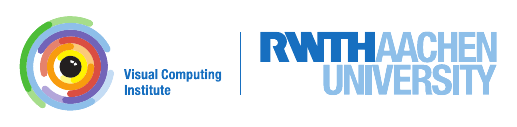</a>
</center>

# Computer Vision Exercises

**Assistants:**
<br>
Markus Knoche &lt;knoche@vision.rwth-aachen.de&gt;
<br>
Jens Piekenbrinck &lt;piekenbrinck@vision.rwth-aachen.de&gt;

The assignments are **not** mandatory!

We want to provide you with an interactive learning experience, so the assignments rely on [Jupyter](https://jupyter.org/) notebooks which you can run locally on your computer. The RWTH also offers a [JupyterHub](https://jupyter.rwth-aachen.de/) where you can run notebooks. If you have any questions, please contact us.

Make sure you fill in any place in *code cells* that says:
```python
# YOUR CODE HERE
raise NotImplementedError()
```

Make sure you fill in any place in *text cells* that says:
<br>

`YOUR ANSWER HERE`


### Submission:

⏰ Due date: 2025-04-17 08:00:00

**Important**:
Follow the instructions below when submitting your attempt.\
Submissions not following these instructions will not be graded.

1. Add the names and matriculation numbers of all team members below. Only **one team member should upload** the solutions.
2. **Use jupyter notebook**. Other notebook-editing software (e.g. jupyter-lab, pycharm) might corrupt the notebook files and could have issues with displaying matplotlib interactively.
3. **Do not remove, modify or duplicate** any given cells, except those in which you need to fill in your implementation. You can add new cells in order to present additional texts or plots.
4. **Restart the kernel and re-run the whole notebook** once before submission. After this step, the cell id should be incremental from top to bottom, and all plots should be displayed.
5. **Submit only the `.ipynb` files**, do not upload archives (zip, rar, tar, etc.), images or datasets.
6. **Do not change the filenames** of the `.ipynb` files.

Team members (names and matriculation numbers):
* 
* 
* 
* 

In [131]:
import cv2
import imageio.v3 as iio
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

# Gaussian Filtering
In the following, you will implement a method which generates and applies a Gaussian filter for a given variance and number of samples.

In [132]:
# Some convenience functions.


def plot_multiple(images, titles, colormap="gray", max_columns=np.inf, share_axes=True):
    """Plot multiple images as subplots on a grid."""
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(n_cols * 4, n_rows * 4),
        squeeze=False,
        sharex=share_axes,
        sharey=share_axes,
    )

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis("off")

    if not isinstance(colormap, (list, tuple)):
        colormaps = [colormap] * n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)

    fig.tight_layout()

Start by writing a function ``gauss`` which creates a 1D Gaussian from a given vector of integer indices $\mathtt{x = [-w, \ldots, w]}$:
$$
    \mathtt{G[i]} = \frac{1}{\sqrt{2\pi}\sigma}\operatorname{exp}\biggl(-\frac{\mathtt{x[i]}^2}{2\sigma^2}\biggr)
$$
where $\sigma$ is the standard deviation.

Tip: In NumPy the best practice is to use functions on entire arrays at once, instead of iterating over items one by one. This makes the code easier to understand and also faster (since the actual loop is implemented in C under the hood).

In [133]:
# POINTS: 1

def gauss(x, sigma):
    # return (1/(np.sqrt(2*np.pi)))*np.exp(-((x*x)/(2*sigma*sigma))) # looking at the furmula and writing it down... might not be the best idea 
    
    coeff = 1 / (sigma * np.sqrt(2 * np.pi))
    exponent = -0.5 * (x / sigma) ** 2
    return coeff * np.exp(exponent) # more elaborated version :)
    

Gauss of 5 is 0.00876415024678427


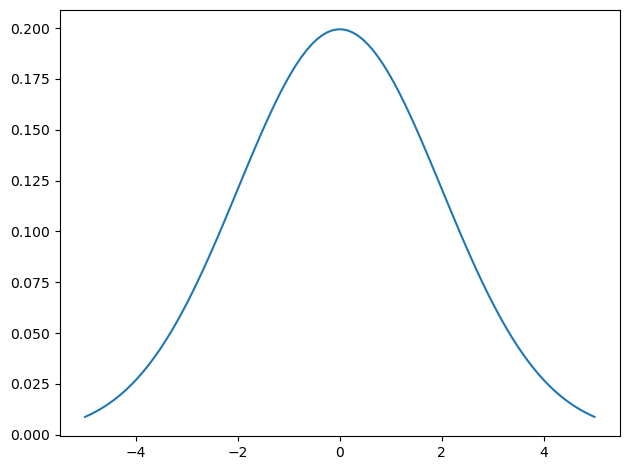

In [134]:
x = np.linspace(-5, 5, 100)
y = gauss(x, sigma=2)
fig, ax = plt.subplots()
ax.plot(x, y)
fig.tight_layout()

print("Gauss of 5 is", gauss(5, sigma=2))

Use the above function to implement a function `gaussian_filter(image, sigma, padding)`, which first generates a Gaussian filter and then applies it to the `image`.
The size of the filter should be $2 \cdot \lceil 3 \sigma \rceil + 1$.
Remember that the Gaussian is separable, *i.e.* that an equivalent 2D result can be obtained through a sequence of two 1D filtering operations.
Do not use any existing implementation for convolution in this part (e.g. `scipy.ndimage.convolve`).
However, you are allowed to use these implementations in the following questions.

You do not have to implement padding, but if you choose to, you can use whichever padding method that is reasonable. The output must have the same dimension with the input.

In [149]:
# Helper function to apply gaussian

def padding(image, half_k):
    # 0 padding
    H, W, C = image.shape
    padded_shape = (H + 2 * half_k, W + 2 * half_k, C)
    padded_image = np.zeros(padded_shape, dtype=image.dtype)

    # Copy original image into the center
    padded_image[half_k:half_k + H, half_k:half_k + W, :] = image

    return padded_image



def apply_1d_filter(image, kernel, axis):
    half_k = kernel.size // 2
    padded_image = padding(image, half_k)
    filtered_image = np.zeros_like(image)

    H, W, C = image.shape

    for c in range(C):
        for i in range(H):
            for j in range(W):
                average = 0.0
                for k in range(-half_k, half_k + 1):
                    if axis == 0:  # y-direction
                        average += kernel[k + half_k] * padded_image[i + k + half_k, j + half_k, c]
                    elif axis == 1: # x-direction
                        average += kernel[k + half_k] * padded_image[i + half_k, j + k + half_k, c]
                filtered_image[i, j, c] = average

    return filtered_image

In [150]:
# POINTS: 5

def gaussian_filter(image, sigma):
    print(f"input size: {image.shape}")
    # create kernel
    kernel_size = int(2 * np.ceil(3 * sigma) + 1)
    kernel = np.array([gauss(i - kernel_size // 2, sigma) for i in range(kernel_size)])
    kernel /= np.sum(kernel)

    # apply convolution
    filtered_x = apply_1d_filter(image, kernel, axis=1)  # x
    filtered_xy = apply_1d_filter(filtered_x, kernel, axis=0)  # y
    print(f"output size: {filtered_xy.shape}")

    return filtered_xy

Read the image ``graf_small.png`` and apply the filters with ``sigma = 2``, ``4``, and ``8``.
Again, choose the kernel size as $2 \cdot \lceil 3 \sigma\rceil + 1$.
What do you observe?

input size: (256, 320, 4)
output size: (256, 320, 4)
input size: (256, 320, 4)
output size: (256, 320, 4)
input size: (256, 320, 4)
output size: (256, 320, 4)


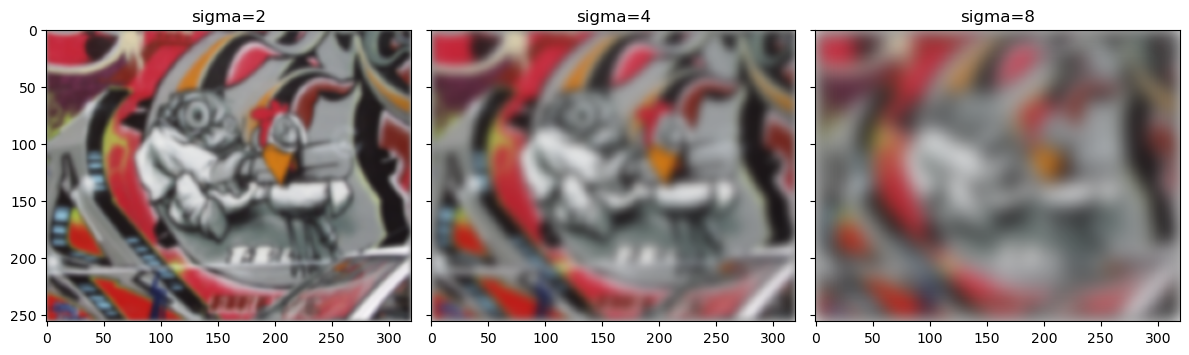

In [151]:
image = iio.imread("graf_small.png")
sigmas = [2, 4, 8]
blurred_images = [gaussian_filter(image, s) for s in sigmas]
titles = [f"sigma={s}" for s in sigmas]

plot_multiple(blurred_images, titles)

OpenCV has many built-in function for image smoothing.
Check out this page:
https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html

Compare the result of ``cv2.GaussianBlur`` with your own implementation by computing the difference image.
Was your implementation correct?

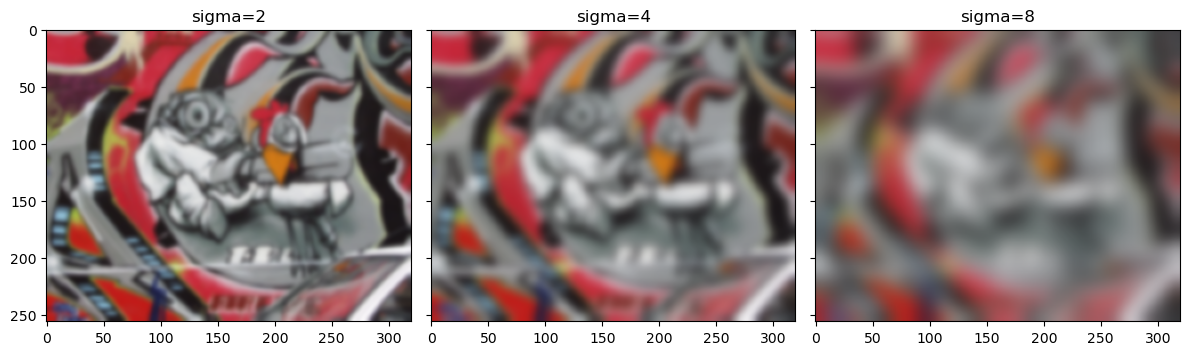

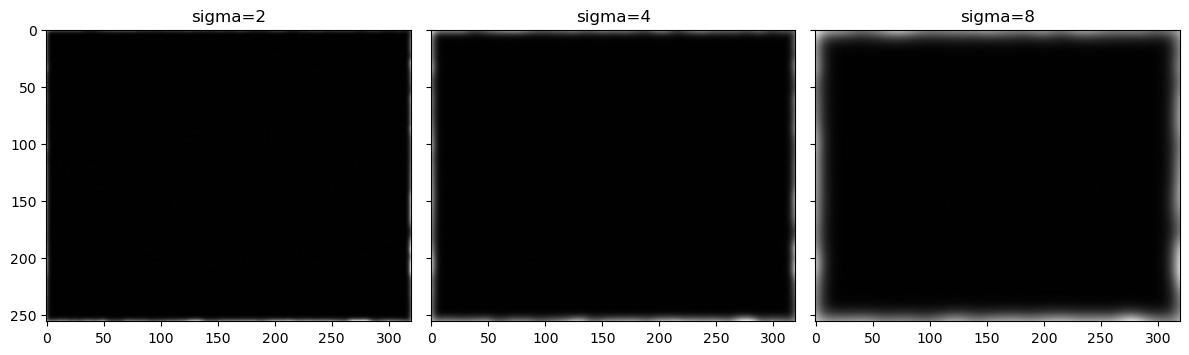

In [152]:
def gauss_cv(image, sigma):
    ks = 2 * int(np.ceil(3 * sigma)) + 1
    return cv2.GaussianBlur(image, (ks, ks), sigma, cv2.BORDER_DEFAULT)


def abs_diff(image1, image2):
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)
    return np.mean(np.abs(image1 - image2), axis=-1)


blurred_images_cv = [gauss_cv(image, s) for s in sigmas]
differences = [abs_diff(x, y) for x, y in zip(blurred_images, blurred_images_cv)]

plot_multiple(blurred_images_cv, titles)
plot_multiple(differences, titles)

# Small differences (around 1-2) can be expected because of rounding
# Mouse over the difference image and see the value in the corner in square brackets

# Fourier Transform

In this part, we look at the effect of filtering in Fourier space.
This gives us a different way of looking at images and yields deeper insights to what is going on when we apply a filter or downsample an image.

In [153]:
# Some Convenience Functions.


def imread_gray(filename):
    """Read grayscale image from our data directory."""
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)


def convolve_with_two(image, kernel1, kernel2):
    """Apply two filters, one after the other."""
    image = ndimage.convolve(image, kernel1, mode="wrap")
    image = ndimage.convolve(image, kernel2, mode="wrap")
    return image


def fourier_spectrum(im):
    normalized_im = im / np.sum(im)
    f = np.fft.fft2(normalized_im)
    return np.fft.fftshift(f)


def log_magnitude_spectrum(im):
    return np.log(np.abs(fourier_spectrum(im)) + 1e-8)


def plot_with_spectra(images, titles):
    """Plots a list of images in the first column and the logarithm of their
    magnitude spectrum in the second column."""

    assert len(images) == len(titles)
    n_cols = 2
    n_rows = len(images)
    fig, axes = plt.subplots(n_rows, 2, figsize=(n_cols * 4, n_rows * 4), squeeze=False)

    spectra = [log_magnitude_spectrum(im) for im in images]

    lower = min(np.percentile(s, 0.1) for s in spectra)
    upper = min(np.percentile(s, 99.999) for s in spectra)
    normalizer = mpl.colors.Normalize(vmin=lower, vmax=upper)

    for ax, image, spectrum, title in zip(axes, images, spectra, titles):
        ax[0].imshow(image, cmap="gray")
        ax[0].set_title(title)
        ax[0].set_axis_off()
        ax[1].imshow(spectrum, norm=normalizer, cmap="viridis")
        ax[1].set_title("Log magnitude spectrum")
        ax[1].set_axis_off()

    fig.tight_layout()


def gauss(x, sigma):
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-(x**2) / 2 / sigma**2)


def generate_pattern():
    x = np.linspace(0, 1, 256, endpoint=False)
    y = np.sin(x**2 * 16 * np.pi)
    return np.outer(y, y) / 2 + 0.5

**Plotting demo:**
This is how you can load example images and plot the logarithm of its magnitude spectrum.
Low frequencies appear near the center and higher frequencies towards the outside.
Greener (lighter) colors mean higher values. The color scale is consistent within the subplots of a single plot, but may differ in different plots.

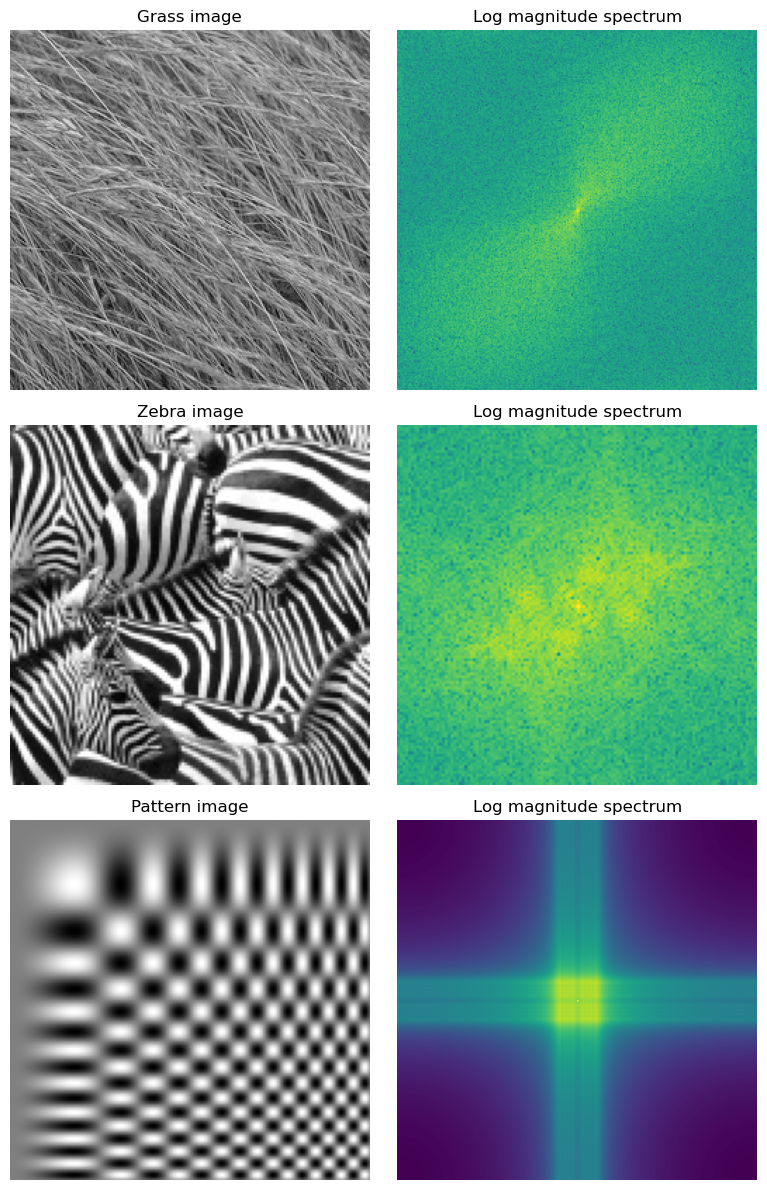

In [154]:
im_grass = imread_gray("grass.jpg")
im_zebras = imread_gray("zebras.jpg")
im_pattern = generate_pattern()
plot_with_spectra(
    [im_grass, im_zebras, im_pattern], ["Grass image", "Zebra image", "Pattern image"]
)

## Blurring

Consider one of the images (`im_grass` is a good choice). Implement `filter_box(image, sigma)` that outputs the box-filtered version of `image`, using `convolve_with_two` (since the box filter is separable). Compute the size of the box filter as `size = int(round(sigma * 12**0.5))` (read [this paper](https://www.peterkovesi.com/papers/FastGaussianSmoothing.pdf) if you are interested in the math behind this formular). 

In [ ]:
# POINTS: 2

def filter_box(image, sigma):
    # YOUR CODE HERE
    raise NotImplementedError()

Implement `filter_gauss(image, kernel_factor, sigma)` using `convolve_with_two`. The parameter `kernel_factor` defines the half size of the kernel relative to sigma (our rule of thumb from the lecture was to set this as 3).

In [ ]:
# POINTS: 2

def filter_gauss(image, kernel_factor, sigma):
    # YOUR CODE HERE
    raise NotImplementedError()

Plot the image and its blurred versions (with the box and the Gauss filter) along with their spectra using `plot_with_spectra()`. Vary the size of the box filter. What do you observe? For the Gaussian, change sigma.  What happens if you increase or decrease the `kernel_factor` compared to our rule-of-thumb value 3?

In [ ]:
sigma = 3
im = im_grass
gauss_filtered = filter_gauss(im, kernel_factor=6, sigma=sigma)
box_filtered = filter_box(im, sigma=sigma)
plot_with_spectra(
    [im, box_filtered, gauss_filtered], ["Image", "Box filtered", "Gauss filtered"]
)

## Sampling and aliasing

Implement a function `sample_with_gaps(image, period)`, where `period` is an integer and defines the distance between two sampled points in pixels. The output should have the same size as `image` but have zeros everywhere except at the sampled points, where it should be equal to `image`. For example if `period=2` then every second row and every second column of the image should be zero in the output.

In addition, implement `sample_without_gaps(image, period)`, which is like `sample_with_gaps` but the output does not contain gaps (rows and columns of zeros) and therefore the output size is smaller.

Hint: These two functions can easily be realized with Numpy indexing (see this [link](https://numpy.org/doc/stable/user/basics.indexing.html#basics-indexing) if you need an introduction). Do not use for-loop.

In [ ]:
# POINTS: 2

def sample_with_gaps(im, period):
    # YOUR CODE HERE
    raise NotImplementedError()


def sample_without_gaps(im, period):
    # YOUR CODE HERE
    raise NotImplementedError()

Sample the `im_zebras` image with a period of 2 pixels and plot the original and sampled images along with their spectra. 
What effect do you see in the resulting magnitude spectrum, when sampling with or without gaps?

In [ ]:
N = 4
im = im_zebras
sampled_gaps = sample_with_gaps(im, N)
sampled = sample_without_gaps(im, N)

blurred = filter_gauss(im, kernel_factor=6, sigma=4)
blurred_and_sampled_gaps = sample_with_gaps(blurred, N)
blurred_and_sampled = sample_without_gaps(blurred, N)

plot_with_spectra(
    [im, sampled_gaps, sampled, blurred, blurred_and_sampled_gaps, blurred_and_sampled],
    [
        "Original",
        "Sampled (w/ gaps)",
        "Sampled",
        "Gauss blurred",
        "Blurred and s. (w/ gaps)",
        "Blurred and s.",
    ],
)

Consider the image `im_pattern` and sample it with a period of 4, 8 and 16 and plot the resulting spectra. What happens as you increase the sampling period?
Now look at what happens when **Gaussian blurring** is applied before sampling, with different sigma values. Approximately what sigma do you need for avoiding artifacts when `period=16`?

In [ ]:
N = 16
image = im_pattern
downsampled_gaps = sample_with_gaps(im_pattern, N)
downsampled = sample_without_gaps(im_pattern, N)

blurred = filter_gauss(image, kernel_factor=6, sigma=12)
blurred_and_downsampled_gaps = sample_with_gaps(blurred, N)
blurred_and_downsampled = sample_without_gaps(blurred, N)

plot_with_spectra(
    [
        im_pattern,
        downsampled_gaps,
        downsampled,
        blurred,
        blurred_and_downsampled_gaps,
        blurred_and_downsampled,
    ],
    [
        "Original",
        "Downsampled (w/ gaps)",
        "Downsampled (no gaps)",
        "Gauss blurred",
        "Blurred and ds. (w/ gaps)",
        "Blurred and downs. (no gaps)",
    ],
)

# Image Derivatives
This task introduces image derivative operators.

In [ ]:
# Some Convenience Functions.


def convolve_with_two(image, kernel1, kernel2):
    """Apply two filters, one after the other."""
    image = ndimage.convolve(image, kernel1)
    image = ndimage.convolve(image, kernel2)
    return image


def imread_gray(filename):
    """Read grayscale image."""
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)


def plot_multiple(images, titles, colormap="gray", max_columns=np.inf, share_axes=True):
    """Plot multiple images as subplots on a grid."""
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(n_cols * 4, n_rows * 4),
        squeeze=False,
        sharex=share_axes,
        sharey=share_axes,
    )

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis("off")

    if not isinstance(colormap, (list, tuple)):
        colormaps = [colormap] * n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)

    fig.tight_layout()


def gauss(x, sigma):
    return 1.0 / np.sqrt(2.0 * np.pi) / sigma * np.exp(-(x**2) / 2.0 / sigma**2)

Implement a function for creating a Gaussian derivative filter in 1D according to the following equation
\begin{eqnarray}
    \frac{d}{dx} G &=& \frac{d}{dx} \frac{1}{\sqrt{2\pi}\sigma} \operatorname{exp}\biggl(-\frac{x^2}{2\sigma^2}\biggr) \\
			       &=& -\frac{1}{\sqrt{2\pi}\sigma^3}x \operatorname{exp}\biggl(-\frac{x^2}{2\sigma^2}\biggr)
\end{eqnarray}
Your function should take a vector of integer values $x$ and the standard deviation ``sigma`` as arguments.

In [ ]:
# POINTS: 1

def gaussdx(x, sigma):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
x = np.linspace(-5, 5, 100)
y = gaussdx(x, sigma=1.0)
fig, ax = plt.subplots()
ax.plot(x, y)
fig.tight_layout()

The effect of a filter can be studied by observing its so-called *impulse response*.
For this, create a test image in which only the central pixel has a non-zero value (called an *impulse*).

In [ ]:
# POINTS: 1

def make_impulse_image(size=25):
    # YOUR CODE HERE
    raise NotImplementedError()
    return impulse

What happens when you apply the following filter combinations on the impulse image?

- first ``gaussian``, then ``gaussian^T``.
- first ``gaussian``, then ``derivative^T``.
- first ``derivative``, then ``gaussian^T``.
- first ``gaussian^T``, then ``derivative``.
- first ``derivative^T``, then ``gaussian``.

Display the result images with the `plot_multiple` function. Describe your result.

In [ ]:
# create kernels
sigma = 6.0
kernel_radius = int(3.0 * sigma)
x = np.arange(-kernel_radius, kernel_radius + 1)[np.newaxis]
G = gauss(x, sigma)
D = gaussdx(x, sigma)

impulse = make_impulse_image()
images = [
    impulse,
    convolve_with_two(impulse, G, G.T),
    convolve_with_two(impulse, G, D.T),
    convolve_with_two(impulse, D, G.T),
    convolve_with_two(impulse, G.T, D),
    convolve_with_two(impulse, D.T, G),
]

titles = [
    "original",
    "first G, then G^T",
    "first G, then D^T",
    "first D, then G^T",
    "first G^T, then D",
    "first D^T, then G",
]

plot_multiple(images, titles, max_columns=3)

Create a new function ``gaussderiv`` using the functions ``gauss`` and ``gaussdx`` directly.
The new function should return the 2D Gaussian derivatives of an input image in $x$ and $y$ direction.
Try the function on the given example images.

In [ ]:
# POINTS: 2

def gauss_derivs(image, sigma):
    kernel_radius = int(3.0 * sigma)
    # YOUR CODE HERE
    raise NotImplementedError()
    return image_dx, image_dy

In [ ]:
image = imread_gray("tomatoes.png")
grad_dx, grad_dy = gauss_derivs(image, sigma=5.0)
plot_multiple(
    [image, grad_dx, grad_dy],
    ["Image", "Derivative in x-direction", "Derivative in y-direction"],
)

In a similar manner, create a new function ``gauss_second_derivs`` that returns the 2D second Gaussian derivatives $\frac{d^2}{dx^2}$, $\frac{d^2}{dx dy}$ and $\frac{d^2}{dy^2}$ of an input image.
Try the function on the given example images.

In [ ]:
# POINTS: 2

def gauss_second_derivs(image, sigma):
    kernel_radius = int(3.0 * sigma)
    # YOUR CODE HERE
    raise NotImplementedError()

    return image_dxx, image_dxy, image_dyy

In [ ]:
image = imread_gray("coins1.jpg")
grad_dxx, grad_dxy, grad_dyy = gauss_second_derivs(image, sigma=2.0)
plot_multiple([image, grad_dxx, grad_dxy, grad_dyy], ["Image", "Dxx", "Dxy", "Dyy"])

In [ ]:
image = imread_gray("circuit.png")
grad_dxx, grad_dxy, grad_dyy = gauss_second_derivs(image, sigma=2.0)
plot_multiple([image, grad_dxx, grad_dxy, grad_dyy], ["Image", "Dxx", "Dxy", "Dyy"])

Create a new function ``image_gradients_polar`` that returns two images with the magnitude and orientation of the gradient for each pixel of the input image. Try the function on the given example images.

In [ ]:
# POINTS: 2

def image_gradients_polar(image, sigma):
    # YOUR CODE HERE
    raise NotImplementedError()
    return magnitude, direction

In [ ]:
image = imread_gray("coins1.jpg")
grad_mag, grad_dir = image_gradients_polar(image, sigma=2.0)

# Note: the twilight colormap only works since Matplotlib 3.0, use 'gray' in earlier versions.
plot_multiple(
    [image, grad_mag, grad_dir],
    ["Image", "Magnitude", "Direction"],
    colormap=["gray", "gray", "twilight"],
)

In [ ]:
image = imread_gray("circuit.png")
grad_mag, grad_theta = image_gradients_polar(image, sigma=2.0)
plot_multiple(
    [image, grad_mag, grad_theta],
    ["Image", "Magnitude", "Direction"],
    colormap=["gray", "gray", "twilight"],
)

Create a new function ``laplace`` that returns an image with the Laplacian-of-Gaussian for each pixel of the input image.
Try the function on the given example images

In [ ]:
# POINTS: 2

def laplace(image, sigma):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
image = imread_gray("coins1.jpg")
lap = laplace(image, sigma=2.0)
plot_multiple([image, lap], ["Image", "Laplace"])

In [ ]:
image = imread_gray("circuit.png")
lap = laplace(image, sigma=2.0)
plot_multiple([image, lap], ["Image", "Laplace"])